Inf2 – Foundations of Data Science

# A/B testing

David Sterratt 2020-2024

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import beta

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [3, 2]

## Click-through A/B test

### Estimation approach: confidence intervals with the bootstrap method

In [2]:
n = 1000 # Numbers in group A and group B

# Observed proportions
pAhat = 0.70
pBhat = 0.72
B = 10000

def bootstrap_prop(pAhat, pBhat, n, B=10000):
    dhat = pAhat - pBhat
        
    # Difference in numbers
    dstar = pd.Series(np.zeros(B))
    for j in range(B):
        fAstar = binom.rvs(n, pAhat)/n
        fBstar = binom.rvs(n, pBhat)/n
        dstar[j] = fAstar - fBstar
        
    ci95 = dstar.quantile([0.025, 0.975])
    return(dstar, dhat, ci95)

dstar_1000, dhat_1000, ci95_1000 = bootstrap_prop(pAhat, pBhat, 1000, B)

Proportion of simulations in which the fraction clikcing through in Group A is bigger than the fraction clicking through in Group B is 0.1574


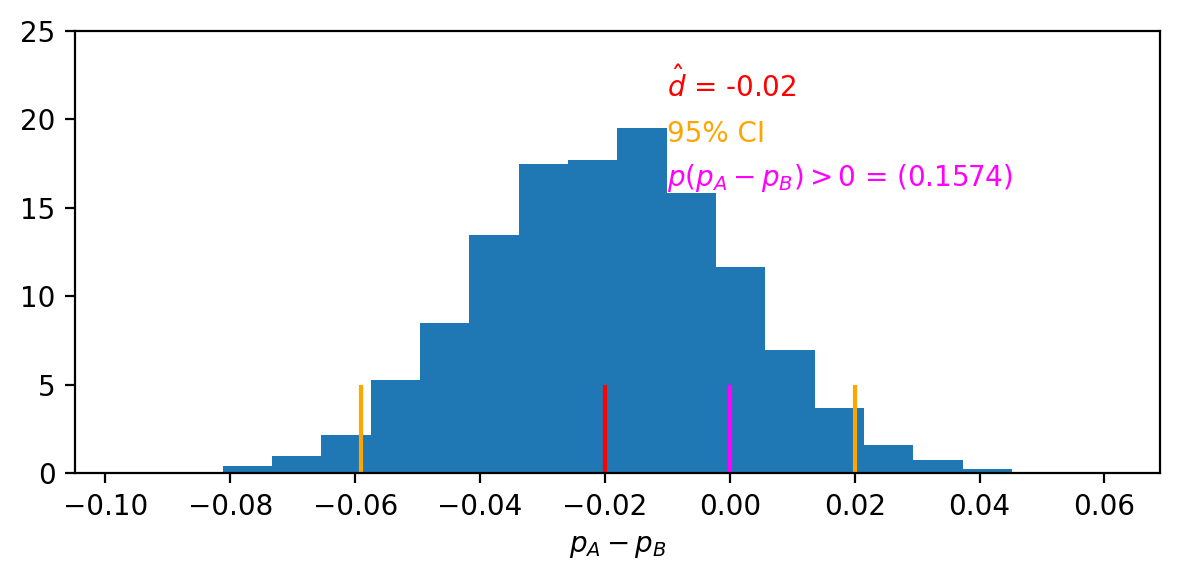

In [37]:
print('Proportion of simulations in which the fraction clikcing through in Group A is bigger than the fraction clicking through in Group B is %2.4f'%(np.sum(dstar_1000>0)/B))

plt.figure(figsize=(6,3))

def plot_bootstrap(dstar, dhat, ci95, ymax=25, xann=-0.01, type="estimate"):
    # type can also be hypothesis_test
    plt.hist(dstar, 20, density=True)
    plt.xlabel('$p_A - p_B$')
    plt.ylim([0, ymax])
    plt.vlines(dhat, 0, ymax/5, color='red')
    plt.vlines(dstar.quantile([0.025, 0.975]), 0, ymax/5, color='orange')
    plt.vlines(0, 0, ymax/5, color='magenta')

    plt.annotate('$\hat{d}$ = %2.2f'%(dhat), (xann, ymax*.85), color='red')
    plt.annotate('95% CI' if type=='estimate' else 'Rejection region boundaries' + ' = (%2.2f, %2.2f)'%(ci95.loc[0.025], ci95.loc[0.975]), (xann, ymax*.75), color='orange')
    if type == 'estimate':
        plt.annotate('$p(p_A - p_B)>0$ = (%2.4f)'%(np.sum(dstar > 0)/B), (xann, ymax*.65), color='magenta')


plot_bootstrap(dstar_1000, dhat_1000, ci95_1000)
plt.tight_layout()
plt.savefig('ab-boot.png')
plt.savefig('ab-boot.pdf')

### Bootstrap estimate of sample size

In [4]:
dstar_10000, dhat_10000, ci95_10000 = bootstrap_prop(pAhat, pBhat, 10000, B)
print(np.sum(dstar_10000 > 0)/B)

0.0014


In [5]:
dstar_5000, dhat_5000, ci95_5000 = bootstrap_prop(pAhat, pBhat, 5000, B)
print(np.sum(dstar_5000 > 0)/B)

0.0143


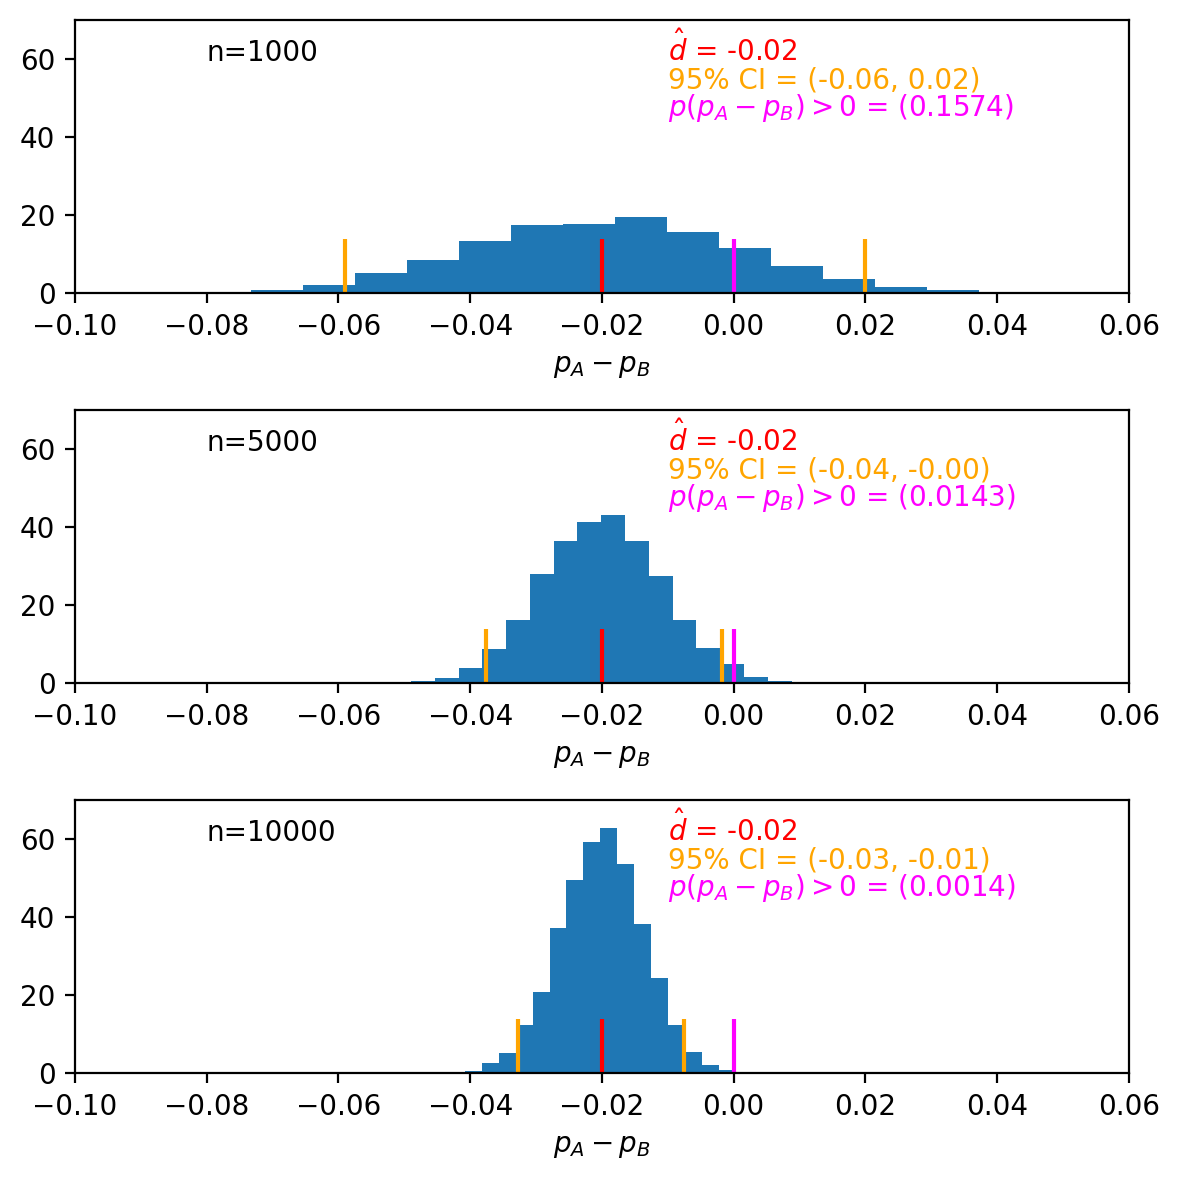

In [6]:
plt.figure(figsize=(6, 6))
plt.subplot(3, 1, 1)
plot_bootstrap(dstar_1000, dhat_1000, ci95_1000, ymax=70)
plt.xlim([-0.1, 0.06])
plt.annotate("n=1000", (-0.08, 70*.85))

plt.subplot(3, 1, 2)
plot_bootstrap(dstar_5000, dhat_5000, ci95_5000, ymax=70)
plt.annotate("n=5000", (-0.08, 70*.85))
plt.xlim([-0.1, 0.06])

plt.subplot(3, 1, 3)
plot_bootstrap(dstar_10000, dhat_10000, ci95_10000, ymax=70)
plt.annotate("n=10000", (-0.08, 70*.85))
plt.xlim([-0.1, 0.06])

plt.tight_layout()
plt.savefig('ab-boot-n.pdf')
plt.savefig('ab-boot-n.png')

### Estimation approach: confidence intervals obtained theoretically

See the lecture notes for this worked example, which gives the same result as for the bootstrap

In [63]:
n = 1000
# The variances of nA and nB (not actually needed)
sigma_nA2 = n*pAhat*(1-pAhat)
sigma_nB2 = n*pBhat*(1-pBhat)

# The squared standard error of the estimators of pA and pB
se_pA2 = pAhat*(1-pAhat)/n
se_pB2 = pBhat*(1-pBhat)/n

# The squared standard error the estimator of d
se_d2  = se_pA2 + se_pB2

# The standard error of the estimator of d
se_d   = np.sqrt(se_d2)

# The estimator of d
dhat = pAhat - pBhat

# The z-critical value z_{0.025}
z0025 = norm.isf(0.025)

print('\hat d = %2.2f'%(dhat))
print('Standard error of estimator of d (\hat\sigma_{\hat d}) = %1.3f'%(se_d))
print('Value of z which has 2.5%% of z-distribution to its right, z_0.025 = %1.6f'%(z0025)) 
print("Theoretical 95%% CI: (%2.5f, %2.5f)"%(d - se_d*z0025, d + se_d*z0025))

\hat d = -0.02
Standard error of estimator of d (\hat\sigma_{\hat d}) = 0.020
Value of z which has 2.5% of z-distribution to its right, z_0.025 = 1.959964
Theoretical 95% CI: (-0.05976, 0.01976)


## Null hypothesis approach

H<sub>0</sub>: proportions in population A and B are the same

H<sub>a</sub>: proportions in population A and B differ

1. Test statistic: difference in population proportions $\hat d = \hat p_A - \hat p_B$
2. Sampling distribution of null hypothesis: difference $d = p_A - p_B$ where $p_A$ and $p_B$ are generated from binomial distribution with $n$ samples and parameter $p$.

0.025   -0.04
0.975    0.04
dtype: float64
p-value = 0.3175


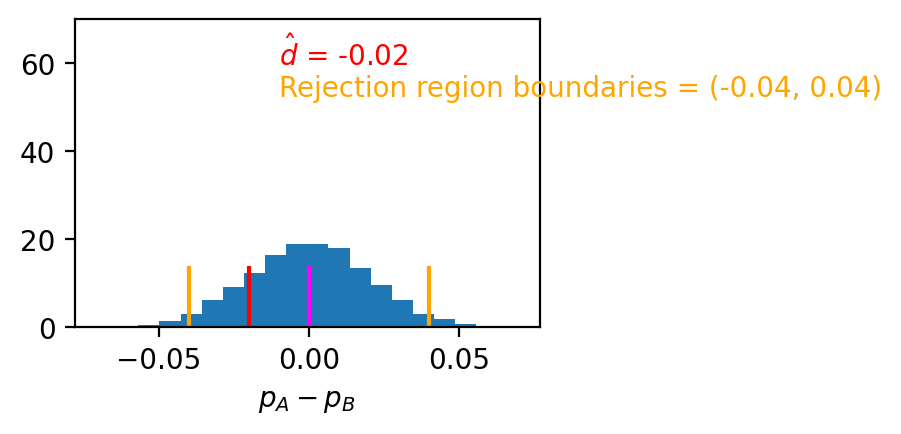

In [61]:
def H0_simulations(pAhat, pBhat, n, B=10000):
    p = (pAhat + pBhat)/2

    # Difference in numbers
    dstar = pd.Series(np.zeros(B))
    for j in range(B):
        fAstar = binom.rvs(n, p)/n
        fBstar = binom.rvs(n, p)/n
        dstar[j] = fAstar - fBstar
        
    reject5 = dstar.quantile([0.025, 0.975])
    p_value = (np.sum(dstar > abs(pAhat - pBhat)) + np.sum(dstar < -abs(pAhat - pBhat)))/B
    return(dstar, reject5, p_value)

H0_dstar_1000, H0_reject5, p_value = H0_simulations(pAhat, pBhat, n=1000)
print(H0_reject5)
plot_bootstrap(H0_dstar_1000, pAhat - pBhat, H0_reject5, ymax=70, type='hypothesis_test')
print('p-value = %2.4f'%(p_value))


0.025   -0.0124
0.975    0.0126
dtype: float64
p-value = 0.002


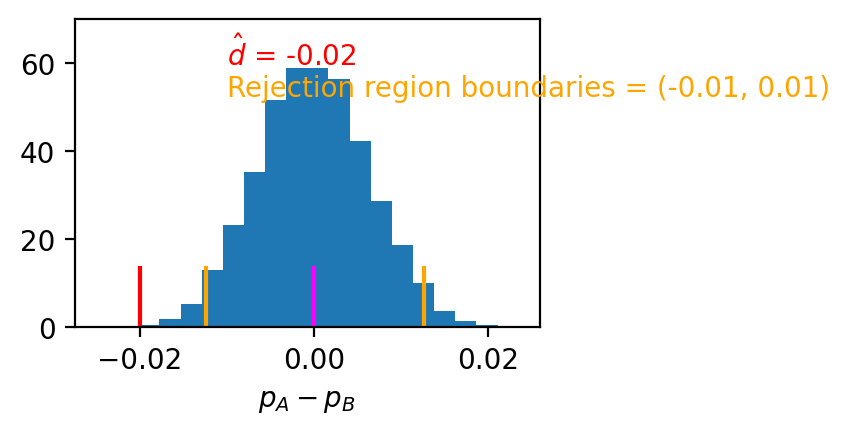

In [47]:
## H0_dstar_1000, H0_reject5, p_value = H0_simulations(pAhat, pBhat, n=10000)
print(H0_reject5)
plot_bootstrap(H0_dstar_1000, pAhat - pBhat, H0_reject5, ymax=70, type='hypothesis_test')
print('p-value = %2.3f'%(p_value))


## Hypothesis testing approach: confidence intervals obtained theoretically

H_<sub>0</sub>: The probability of click through is the same for both groups: $p_\mathrm{A} = p_\mathrm{B} = p$; alternatively that $d = p_\mathrm{A} - p_\mathrm{B} = 0$.

Test statistic: $d = \frac{n_\mathrm{A}}{n} - \frac{n_\mathrm{B}}{n}$.

Distribution of test statistic: $n_A$ and $n_B$ are generated by $n$ draws from a binomial distribution with $p= \frac{n_\mathrm{A} + n_\mathrm{B}}{2n}$. The variance $\sigma^2_{n_A} = \sigma^2_{n_B} = n p (1-p)$. The variance of a sum of random numbers is equal to the sums of the variances so $\sigma^2_d = \frac{1}{n^2}(\sigma^2_{n_A} + \sigma^2_{n_B})=\frac{1}{n}2p(1-p)$

Since $p= 1/2(p_A + p_B)$, we can write:
$\sigma^2_d = \frac{1}{n}2p(1-p) = \frac{1}{n}(p_A+ p_B)(1-\frac{p_A-p_B}{2}) = \frac{1}{n}(p_A(1-p_A/2) + p_B(1-p_B/2))$




In [64]:
n = 1000

phat = (pAhat + pBhat)/2
sigma_d2 = 2*phat*(1-phat)/n
sigma_d = np.sqrt(sigma_d2)

# The z-critical value z_{0.025}
z0025 = norm.isf(0.025)

print('Value of z which has 2.5%% of z-distribution to its right, z_0.025 = %1.6f'%(z0025)) 
print("Boudnaries of 5%% rejection region: (%2.5f, %2.5f)"%(sigma_d*z0025, sigma_d*z0025))


Value of z which has 2.5% of z-distribution to its right, z_0.025 = 1.959964
Boudnaries of 5% rejection region: (0.03977, 0.03977)


In [11]:
Z = (pAhat-pBhat)/sepd
norm.sf(Z)

0.8378863161044898

In [12]:
print("Theoretical 95% CI: (%2.3f, %2.3f)"%(d - sepd*1.96, d + sepd*1.96))

Theoretical CI: (-0.060, 0.020)


## Bayesian

One variable

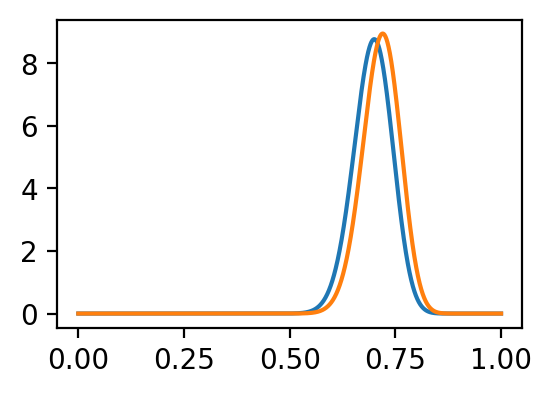

In [13]:
n = 100
nA = n*pAhat
nB = n*pBhat
pA = np.linspace(0, 1, 2000)
pB = pA
pA_nA = beta.pdf(pA, a=nA+1, b=n-nA+1)
pB_nB = beta.pdf(pB, a=nB+1, b=n-nB+1)

plt.plot(pA, pA_nA)
plt.plot(pB, pB_nB)

In [14]:
nB

72.0

## Numeric samples

In [15]:
dat = pd.read_csv('exmp10-05.txt')

In [16]:
dat

ACTmath  semester
0         27         1
1         29         1
2         30         1
3         34         1
4         29         1
..       ...       ...
149       15         2
150       28         2
151       27         2
152       28         2
153       32         2

[154 rows x 2 columns]

In [17]:
sns.boxplot(x='semester', y='ACTmath', data=dat, color='white')
plt.xlabel('Semester')
plt.tight_layout()
plt.savefig('maths.pdf')
plt.savefig('maths.png')

In [18]:
x = dat.loc[dat['semester']==1,'ACTmath']
y = dat.loc[dat['semester']==2,'ACTmath']

x.mean() - y.mean()

2.371621621621621

## Bootstrap

In [19]:
B = 10000
m = len(x)
n = len(y)
dstar = pd.Series(B)
for j in range(B):
    xstar = x.sample(n, replace=True)
    ystar = y.sample(n, replace=True)
    dstar.loc[j] = xstar.mean() - ystar.mean()

ci95 = dstar.quantile([0.025, 0.975])

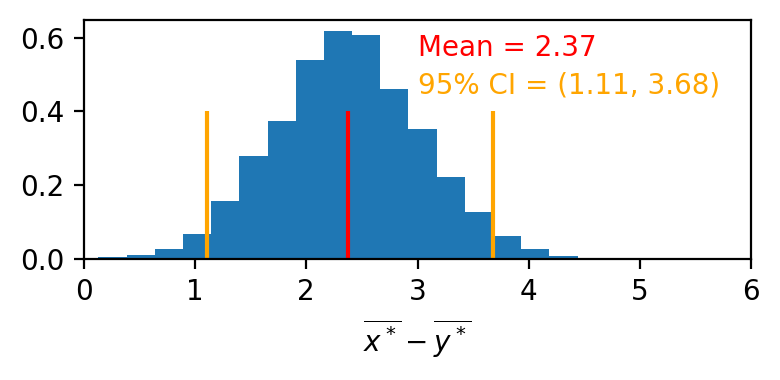

In [20]:
plt.figure(figsize=(4,2))
plt.hist(dstar, 20, density=True)
plt.xlabel('$\overline{x^*}-\overline{y^*}$')
plt.vlines(x.mean()-y.mean(), 0, 0.4, color='red')
plt.annotate('Mean = %2.2f'%(x.mean()-y.mean()), (3, 0.55), color='red')
plt.annotate('95%% CI = (%2.2f, %2.2f)'%(ci95.loc[0.025], ci95.loc[0.975]), (3, 0.45), color='orange')

plt.vlines(dstar.quantile([0.025, 0.975]), 0, 0.4, color='orange')
plt.xlim([0, 6]) 
plt.tight_layout()
plt.savefig('maths-bootstrap.pdf')
plt.savefig('maths-bootstrap.png')


## Theory

In [21]:
m = len(x)
n = len(y)
semx = x.std()/np.sqrt(m)
semy = y.std()/np.sqrt(n)

Z = (x.mean() - y.mean())/(np.sqrt(np.power(semx, 2) + np.power(semy, 2)))
nu = np.power((np.power(semx,2) + np.power(semy,2)), 2)/\
              (np.power(semx, 2)/(m-1) + np.power(semy, 2)/(n-1))


In [22]:
t.sf(Z, nu)

0.0004461152829789135

In [23]:
delta = t.isf(0.025, nu)*np.sqrt(np.power(semx,2)+np.power(semy,2))

In [24]:
[x.mean()-y.mean() - delta, x.mean()-y.mean() + delta]

[1.055114619953228, 3.688128623290014]

In [25]:
x = np.arange(100)

In [26]:
np.quantile(x, [0.025, 0.975])

array([ 2.475, 96.525])